In [33]:
import numpy as np
import pandas as pd
import wave
from scipy.io import wavfile
import os
import librosa
import warnings
from sklearn.utils import shuffle
from sklearn.utils import class_weight
import sklearn
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten, Dropout, Activation, LSTM, SimpleRNN, Conv1D

import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# Read data

In [34]:
train_df = pd.read_csv('./rawdata/train.csv')

In [35]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21375 entries, 0 to 21374
Data columns (total 35 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rating            21375 non-null  float64
 1   playback_used     19575 non-null  object 
 2   ebird_code        21375 non-null  object 
 3   channels          21375 non-null  object 
 4   date              21375 non-null  object 
 5   pitch             21375 non-null  object 
 6   duration          21375 non-null  int64  
 7   filename          21375 non-null  object 
 8   speed             21375 non-null  object 
 9   species           21375 non-null  object 
 10  number_of_notes   21375 non-null  object 
 11  title             21375 non-null  object 
 12  secondary_labels  21375 non-null  object 
 13  bird_seen         19575 non-null  object 
 14  sci_name          21375 non-null  object 
 15  location          21375 non-null  object 
 16  latitude          21375 non-null  object

# Reduce data

In [36]:
train_df = train_df.query("rating>=4")   # データ量削減のために rating が 4 or 5 だけにする

birds_count = {}
for bird_species, count in zip(train_df.ebird_code.unique(), train_df.groupby("ebird_code")["ebird_code"].count().values):
    birds_count[bird_species] = count

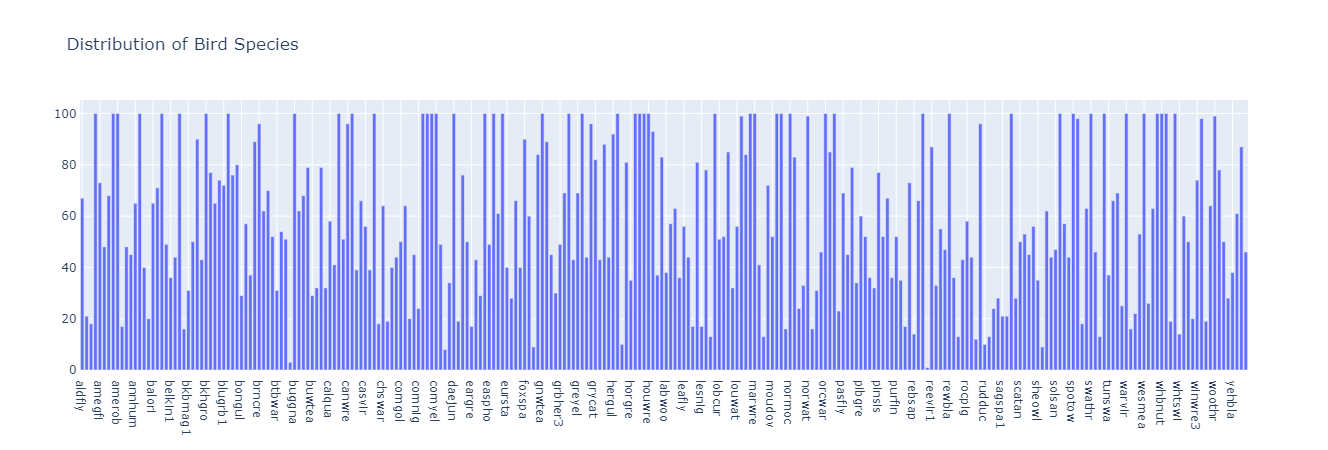

In [37]:
fig = go.Figure(data=[
    go.Bar(y=list(birds_count.values()), x=list(birds_count.keys()))
])

fig.update_layout(title='Distribution of Bird Species')
fig.show()

In [38]:
most_represented_birds = [key for key,value in birds_count.items() if value == 100]   # データ数が100個の鳥だけ使う
train_df = train_df.query("ebird_code in @most_represented_birds")

In [39]:
len(train_df.ebird_code.unique())

49

In [40]:
birds_to_recognise = shuffle(most_represented_birds)[:20]
print(birds_to_recognise)

['amecro', 'amerob', 'horlar', 'redcro', 'sonspa', 'wesmea', 'savspa', 'grhowl', 'daejun', 'bewwre', 'cangoo', 'easmea', 'warvir', 'norfli', 'spotow', 'comter', 'orcwar', 'mallar3', 'herthr', 'ovenbi1']


In [41]:
sequence_length = 50

ebird_to_id = {}
id_to_ebird = {}
ebird_to_id["nocall"] = 0
id_to_ebird[0] = "nocall"
for idx, unique_ebird_code in enumerate(birds_to_recognise):
    ebird_to_id[unique_ebird_code] = str(idx+1)
    id_to_ebird[idx+1] = str(unique_ebird_code)

In [42]:
train_df = shuffle(train_df)
train_df.head()

,rating,playback_used,ebird_code,channels,date,pitch,duration,filename,speed,species,...,xc_id,url,country,author,primary_label,longitude,length,time,recordist,license
7010,4.0,no,daejun,2 (stereo),2012-10-24,Not specified,8,XC138151.mp3,Not specified,Dark-eyed Junco,...,138151,https://www.xeno-canto.org/138151,United States,Paul Driver,Junco hyemalis_Dark-eyed Junco,-75.1254,Not specified,07:15,Paul Driver,Creative Commons Attribution-NonCommercial-Sha...
709,5.0,no,amerob,2 (stereo),2015-05-17,both,62,XC338199.mp3,level,American Robin,...,338199,https://www.xeno-canto.org/338199,United States,Bruce Lagerquist,Turdus migratorius_American Robin,-122.3108,3-6(s),09:30,Bruce Lagerquist,Creative Commons Attribution-NonCommercial-Sha...
12010,5.0,no,linspa,1 (mono),2014-06-30,Not specified,104,XC206124.mp3,Not specified,Lincoln's Sparrow,...,206124,https://www.xeno-canto.org/206124,United States,Eric DeFonso,Melospiza lincolnii_Lincoln's Sparrow,-108.0274,Not specified,09:21,Eric DeFonso,Creative Commons Attribution-NonCommercial-Sha...
18249,5.0,no,spotow,2 (stereo),2018-05-10,Not specified,35,XC418304.mp3,Not specified,Spotted Towhee,...,418304,https://www.xeno-canto.org/418304,United States,Bobby Wilcox,Pipilo maculatus_Spotted Towhee,-115.7399,Not specified,07:30,Bobby Wilcox,Creative Commons Attribution-NonCommercial-Sha...
19708,5.0,no,wewpew,1 (mono),2000-06-12,Not specified,10,XC378357.mp3,Not specified,Western Wood Pewee,...,378357,https://www.xeno-canto.org/378357,United States,Jeremy Minns,Contopus sordidulus_Western Wood-Pewee,-120.5105,Not specified,08:10,Jeremy Minns,Creative Commons Attribution-NonCommercial-Sha...


In [43]:
len(train_df)

4900

In [ ]:
def get_sample(filename, bird, sampling_rate=0):
    if sampling_rate == 0:
        wave_data, wave_rate = librosa.load(filename)
    else:
        wave_data, wave_rate = librosa.load(filename, sampling_rate)
    data_point_per_second = int(sequence_length/5)
    
    #Take 10 data points every second
    prepared_sample = wave_data[0::int(wave_rate/data_point_per_second)]
    #We normalize each sample before extracting 5s samples from it
    normalized_sample = sklearn.preprocessing.minmax_scale(prepared_sample, axis=0)
    
    #only take 5s samples and add them to the dataframe
    song_sample = []
    sample_length = 5*data_point_per_second
    samples_from_file = []
    for idx in range(0,len(normalized_sample),sample_length): 
        song_sample = normalized_sample[idx:idx+sample_length]
        if len(song_sample)>=sample_length:
            samples_from_file.append({"song_sample":np.asarray(song_sample).astype(np.float32),
                                            "bird":int(ebird_to_id[bird])})
    return samples_from_file

In [ ]:
%%time
warnings.filterwarnings("ignore")
samples_df = pd.DataFrame(columns=["song_sample","bird"])

#We limit the number of audio files being sampled to 6000 in this notebook to save time
#However, we have already limited the number of bird species
sample_limit = 5000
sample_list = []
with tqdm(total=sample_limit) as pbar:
    for idx, row in train_df[:sample_limit].iterrows():
        pbar.update(1)
        try:
            audio_file_path = "./rawdata/train_audio/"
            audio_file_path += row.ebird_code
            
            if row.ebird_code in birds_to_recognise:
                sample_list += get_sample('{}/{}'.format(audio_file_path, row.filename), row.ebird_code)
            else:
                sample_list += get_sample('{}/{}'.format(audio_file_path, row.filename), "nocall")
        except:
            print("{} is corrupted".format(audio_file_path))
            
            
#Generate some fake random samples to represent "no calls", being 5% of the total samples
number_of_nocalls = int(len(samples_df)*0.05)
for idx in range(0,number_of_nocalls):
    synthetic_nocall = sklearn.preprocessing.minmax_scale(np.random.randn(sequence_length), axis=0)
    sample_list += [{"song_sample":synthetic_nocall,
                    "bird":ebird_to_id["nocall"]}]
    
samples_df = pd.DataFrame(sample_list)

In [ ]:
samples_df = shuffle(samples_df)
samples_df[:10]

In [ ]:
plt.plot(samples_df.iloc[0].song_sample)
plt.show()

# Model Creation

In [ ]:
training_percentage = 0.9
training_item_count = int(len(samples_df)*training_percentage)
validation_item_count = len(samples_df)-int(len(samples_df)*training_percentage)
training_df = samples_df[:training_item_count]
validation_df = samples_df[training_item_count:]

In [ ]:
model = Sequential()
model.add(LSTM(32, return_sequences=True, recurrent_dropout=0.2,input_shape=(None, sequence_length)))
model.add(LSTM(32))
model.add(Dense(128))
model.add(Dropout(0.3))
model.add(Dense(len(ebird_to_id.keys()), activation="softmax"))

model.summary()

In [ ]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.7),
             EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]
model.compile(loss="categorical_crossentropy", optimizer='adam')

In [ ]:
X_train = np.asarray(np.reshape(np.asarray([np.asarray(x) for x in training_df["song_sample"]]),(training_item_count,1,sequence_length))).astype(np.float32)
groundtruth = np.asarray([np.asarray(x) for x in training_df["bird"]]).astype(np.float32)
Y_train = to_categorical(
                groundtruth, num_classes=len(ebird_to_id.keys()), dtype='float32'
            )


X_validation = np.asarray(np.reshape(np.asarray([np.asarray(x) for x in validation_df["song_sample"]]),(validation_item_count,1,sequence_length))).astype(np.float32)
validation_groundtruth = np.asarray([np.asarray(x) for x in validation_df["bird"]]).astype(np.float32)
Y_validation = to_categorical(
                validation_groundtruth, num_classes=len(ebird_to_id.keys()), dtype='float32'
            )

In [ ]:
class_weights = class_weight.compute_class_weight("balanced", samples_df.bird.unique(), samples_df.bird.values)
class_weights_dict = {i : class_weights[i] for i in samples_df.bird.unique()}

# Model Training

In [ ]:
history = model.fit(X_train, Y_train,
          epochs = 200, 
          batch_size = 32, 
          validation_data=(X_validation, Y_validation),
          class_weight=class_weights_dict,
          callbacks=callbacks)

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss over epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [ ]:
preds = model.predict(X_validation)
validation_df = pd.DataFrame(columns=["prediction", "groundtruth", "correct_prediction"])

for pred, groundtruth in zip(preds[:30], Y_validation[:30]):
    validation_df = validation_df.append({"prediction":id_to_ebird[np.argmax(pred)], 
                                       "groundtruth":id_to_ebird[np.argmax(groundtruth)], 
                                       "correct_prediction":np.argmax(pred)==np.argmax(groundtruth)}, ignore_index=True)
validation_df

# Prediction

In [ ]:
model.load_weights("best_model.h5")

In [ ]:
def predict_submission(df, audio_file_path):
        
    loaded_audio_sample = []
    previous_filename = ""
    data_point_per_second = 10
    sample_length = 5*data_point_per_second
    wave_data = []
    wave_rate = None
    
    for idx,row in df.iterrows():
        #I added this exception as I've heard that some files may be corrupted.
        try:
            if previous_filename == "" or previous_filename!=row.audio_id:
                filename = '{}/{}.mp3'.format(audio_file_path, row.audio_id)
                wave_data, wave_rate = librosa.load(filename)
                prepared_sample = wave_data[0::int(wave_rate/data_point_per_second)]
                sample = sklearn.preprocessing.minmax_scale(prepared_sample, axis=0)
            previous_filename = row.audio_id

            #basically allows to check if we are running the examples or the test set.
            if "site" in df.columns:
                if row.site=="site_1" or row.site=="site_2":
                    song_sample = np.array(sample[int(row.seconds-5)*data_point_per_second:int(row.seconds)*data_point_per_second])
                elif row.site=="site_3":
                    #for now, I only take the first 5s of the samples from site_3 as they are groundtruthed at file level
                    song_sample = np.array(sample[0:sample_length])
            else:
                #same as the first condition but I isolated it for later and it is for the example file
                song_sample = np.array(sample[int(row.seconds-5)*data_point_per_second:int(row.seconds)*data_point_per_second])
            
            input_data = np.reshape(np.asarray([song_sample]),(1,sequence_length)).astype(np.float32)
            prediction = model.predict(np.array([input_data]))
            
            #condition to ensure that at least one output is activated with "some" confidence
            if any(prediction[0]>0.3):
                predicted_bird = id_to_ebird[np.argmax(prediction)]
                df.at[idx,"birds"] = predicted_bird
            else:
                df.at[idx,"birds"] = "nocall"
        except:
            df.at[idx,"birds"] = "nocall"
    return df

In [ ]:
audio_file_path = "/kaggle/input/birdsong-recognition/example_test_audio"
example_df = pd.read_csv("/kaggle/input/birdsong-recognition/example_test_audio_summary.csv")
#Ajusting the example filenames and creating the audio_id column to match with the test file.
example_df["audio_id"] = [ "BLKFR-10-CPL_20190611_093000.pt540" if filename=="BLKFR-10-CPL" else "ORANGE-7-CAP_20190606_093000.pt623" for filename in example_df["filename"]]

if os.path.exists(audio_file_path):
    example_df = predict_submission(example_df, audio_file_path)
example_df

In [ ]:
test_file_path = "/kaggle/input/birdsong-recognition/test_audio"
test_df = pd.read_csv("/kaggle/input/birdsong-recognition/test.csv")
submission_df = pd.read_csv("/kaggle/input/birdsong-recognition/sample_submission.csv")

if os.path.exists(test_file_path):
    submission_df = predict_submission(test_df, test_file_path)

submission_df[["row_id","birds"]].to_csv('submission.csv', index=False)
submission_df.head()